In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_stata("data/United States/cumulative_2006-2021.dta")
df["state"] = df["state"].str.upper()
df.head()

,year,case_id,weight,weight_cumulative,state,st,cong,cong_up,state_post,st_post,...,voted_rep_chosen,voted_sen_chosen,voted_gov_chosen,rep_current,rep_icpsr,sen1_current,sen1_icpsr,sen2_current,sen2_icpsr,gov_current
0,2006,439219,1.851676,1.487096,NORTH CAROLINA,NC,109,110,North Carolina,NC,...,Richard C. Carsner (D),,,Patrick T. McHenry (R),20522,Elizabeth Dole (R),40303,Richard Burr (R),29548,Michael Easley (D)
1,2006,439224,0.968308,0.777656,OHIO,OH,109,110,Ohio,OH,...,Stephanie Studebaker (D),Sherrod C. Brown (D),Ted Strickland (D),Michael R. Turner (R),20342,Mike DeWine (R),15020,George V. Voinovich (R),49903,Bob Taft (R)
2,2006,439228,1.593441,1.279706,NEW JERSEY,NJ,109,110,New Jersey,NJ,...,Robert E. Andrews (D),Robert Menendez (D),,Robert E. Andrews (D),29132,Robert Menendez (D),29373,Frank R. Lautenberg (D),14914,Jon Corzine (D)
3,2006,439237,1.398529,1.123170,ILLINOIS,IL,109,110,Illinois,IL,...,Janice D. Schakowsky (D),,Rod Blagojevich (D),Janice D. Schakowsky (D),29911,Richard Durbin (D),15021,Barack Obama (D),40502,Rod Blagojevich (D)
4,2006,439238,0.902890,0.725118,NEW YORK,NY,109,110,New York,NY,...,Maurice D. Hinchey (D),Hillary Rodham Clinton (D),Eliot Spitzer (D),Maurice D. Hinchey (D),29380,Charles E. Schumer (D),14858,Hillary Rodham Clinton (D),40105,George Pataki (R)


In [3]:
list(df)

['year',
 'case_id',
 'weight',
 'weight_cumulative',
 'state',
 'st',
 'cong',
 'cong_up',
 'state_post',
 'st_post',
 'dist',
 'dist_up',
 'cd',
 'cd_up',
 'dist_post',
 'dist_up_post',
 'cd_post',
 'cd_up_post',
 'zipcode',
 'county_fips',
 'tookpost',
 'weight_post',
 'rvweight',
 'rvweight_post',
 'starttime',
 'pid3',
 'pid3_leaner',
 'pid7',
 'ideo5',
 'gender',
 'birthyr',
 'age',
 'race',
 'hispanic',
 'citizen',
 'educ',
 'marstat',
 'faminc',
 'union',
 'union_hh',
 'employ',
 'no_healthins',
 'has_child',
 'ownhome',
 'no_milstat',
 'religion',
 'economy_retro',
 'newsint',
 'approval_pres',
 'approval_rep',
 'approval_sen1',
 'approval_sen2',
 'approval_gov',
 'intent_pres_08',
 'intent_pres_12',
 'intent_pres_16',
 'intent_pres_20',
 'voted_pres_08',
 'voted_pres_12',
 'voted_pres_16',
 'voted_pres_20',
 'intent_pres_party',
 'voted_pres_party',
 'intent_turnout_self',
 'voted_turnout_self',
 'vv_regstatus',
 'vv_party_gen',
 'vv_party_prm',
 'vv_turnout_gvm',
 'vv_turnou

In [4]:
# tookpost:

In [5]:
df.tookpost.unique()

['Took Post-Election Survey', 'Did Not Take Post-Election Survey', NaN]
Categories (2, object): ['Did Not Take Post-Election Survey' < 'Took Post-Election Survey']

In [6]:
df_filtered = df[["year", "state", "pid7", "weight"]]
# df_filtered = df_filtered[df_filtered["tookpost"] == "Took Post-Election Survey"]
df_filtered["ideology"] = df_filtered["pid7"].replace({
    "Strong Democrat": -3,
    "Not Very Strong Democrat": -2,
    "Lean Democrat": -1,
    "Independent": 0,
    "Lean Republican": 1,
    "Not Very Strong Republican": 2,
    "Strong Republican": 3,
    "Not Sure": np.nan
}).astype(object)

df_filtered = df_filtered[df_filtered["ideology"].isin([-3, -2, -1, 1, 2, 3])]
df_filtered["ideology"] = df_filtered["ideology"].astype(int)
df_filtered["pol_orientation"] = df_filtered["ideology"].apply(lambda x: "LEFT" if x < 0 else "RIGHT")
df_filtered.head()

C:\Users\cnava\AppData\Local\Temp\ipykernel_33524\3088419169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["ideology"] = df_filtered["pid7"].replace({


,year,state,pid7,weight,ideology,pol_orientation
0,2006,NORTH CAROLINA,Strong Democrat,1.851676,-3,LEFT
1,2006,OHIO,Lean Democrat,0.968308,-1,LEFT
2,2006,NEW JERSEY,Strong Democrat,1.593441,-3,LEFT
3,2006,ILLINOIS,Strong Democrat,1.398529,-3,LEFT
4,2006,NEW YORK,Strong Democrat,0.902890,-3,LEFT


In [7]:
output = []

for ii, item in df_filtered.groupby(["year", "state"]):
    year, state = ii

    left = item[item["pol_orientation"] == "LEFT"]
    right = item[item["pol_orientation"] == "RIGHT"]

    try:    
        vleft = np.average(left["ideology"].astype(int), weights=left["weight"])
        vright = np.average(right["ideology"].astype(int), weights=right["weight"])


        output.append({
            "polarization2": np.absolute(vleft - vright),
            "year": year,
            "state": state,
            "N": min(left.shape[0] + right.shape[0], 99999999)
        })
    except:
        pass

data = pd.DataFrame(output)
data = data[data["N"] >= 30]
data.to_csv("data_output/United States/Polarization_CCNES.csv", index=False)

data

,polarization2,year,state,N
0,4.491780,2006,ALABAMA,420
1,3.705442,2006,ALASKA,108
2,4.307511,2006,ARIZONA,858
3,4.584377,2006,ARKANSAS,288
4,4.350901,2006,CALIFORNIA,3213
...,...,...,...,...
810,4.602033,2021,VIRGINIA,545
811,4.221524,2021,WASHINGTON,512
812,4.671238,2021,WEST VIRGINIA,146
813,4.572532,2021,WISCONSIN,403


In [8]:
output = []

for ii, item in df_filtered.groupby(["year"]):
  year = ii

  left = item[item["pol_orientation"] == "LEFT"]
  right = item[item["pol_orientation"] == "RIGHT"]

  try:    
    vleft = np.average(left["ideology"].astype(int), weights=left["weight"])
    vright = np.average(right["ideology"].astype(int), weights=right["weight"])

    output.append({
      "polarization2": np.absolute(vleft - vright),
      "polarization": vleft + vright,
      "year": year,
      "state": "All",
      "N": min(left.shape[0] + right.shape[0], 99999999)
    })
    output.append({
      "polarization2": np.absolute(vleft - vright),
      "polarization": vleft,
      "year": year,
      "state": "Left",
      "N": min(left.shape[0] + right.shape[0], 99999999)
    })
    output.append({
      "polarization2": np.absolute(vleft - vright),
      "polarization": vright,
      "year": year,
      "state": "Right",
      "N": min(left.shape[0] + right.shape[0], 99999999)
    })
  except:
      pass

data = pd.DataFrame(output)


C:\Users\cnava\AppData\Local\Temp\ipykernel_33524\2192865382.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for ii, item in df_filtered.groupby(["year"]):


(-3.0, 3.0)

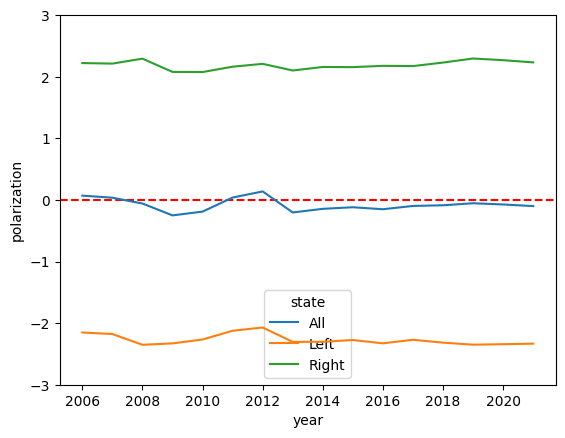

In [9]:
ax = sns.lineplot(x="year", y="polarization", hue="state", data=data, zorder=11)
ax.axhline(y=0, ls="--", color="red", zorder=1)
ax.set_ylim(-3, 3)